In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import json
import itertools
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC']

data_dir = Path("../../../../Data/0archive/")

### Read data

In [2]:
def load_data(*path_globs):
    return pd.concat([
        pd.read_json(json_file, lines=True, encoding="utf-8")
        for json_file in itertools.chain(*[ json_dir.glob(path_glob) for path_glob in path_globs ])
    ], ignore_index=True, sort=False)

In [3]:
json_dir = data_dir / "中時電子報 (www.chinatimes.com) 5030a59d-81fe-11ea-8627-f23c92e71bad/2020-05-tokenized/"
df = load_data("2020-05-*.jsonl")

# take unique by publication_id and keep the biggest version
df = df.sort_values(["id", "version"], ascending=[1, 0])
df = df.drop_duplicates("id", keep="first")

print("The shape of the dataframe: ", df.shape)
df.head()

The shape of the dataframe:  (3073, 6)


,id,producer_id,version,title,text,comments
2230,000c0a09-ed2a-448e-bd72-592d54227023,5030a59d-81fe-11ea-8627-f23c92e71bad,1589036746,"[疫情, 重創, Uber, 大砍, 名, 員工, 財經, 中時, 電子報]","[受新, 冠, 肺炎, 疫情, 衝擊, 共享, 乘車, 服務公司, Uber, 周三, 日,...",[]
755,0029c3dd-82e8-414b-9d35-50dbe3fb5430,5030a59d-81fe-11ea-8627-f23c92e71bad,1588725189,"[杯, 咖啡, 害慘, 散戶, 驚爆, 陸企, ADR, 坑殺, 內幕, 財經, 中時, 電子報]","[清明節, 過後, 號稱, 星巴克, 咖啡, 在, 中國, 最強, 競爭對手, 的, 瑞幸,...",[]
169,002c56d6-e077-4c80-96b5-65cd161cc9a0,5030a59d-81fe-11ea-8627-f23c92e71bad,1588970566,"[億, 紓困, 過關, 廣發, 現金, 落空, 生活, 新聞, 中國時報]","[由, 行政院, 提出, 總金額, 達, 億, 的, 第二, 波, 防疫, 紓困, 預算, ...",[]
3030,0048b95d-dbc7-4680-8d89-c88b236b10cf,5030a59d-81fe-11ea-8627-f23c92e71bad,1588358297,"[確定, 脫, 北, 南韓, 議員, 爆, 金正恩, 上周, 已, 腦死, 國際, 中時, ...","[北韓, 最高, 領導人, 金正恩, 將近, 半月, 未, 出現, 在, 公開場合, 數個,...",[]
3059,008a2d6f-f324-40cb-8f9a-8fd0971dc044,5030a59d-81fe-11ea-8627-f23c92e71bad,1588438028,"[不是, 愷樂, 周揚青, 羅志祥, 被爆, 只, 對, 這, 女神, 認真, 娛樂, 中時...","[羅志祥, 小豬, 周揚, 青年, 情斷, 小豬, 旗下, 唯一, 女藝人, 愷, 樂, 蝴...",[]


### Prepare data

In [4]:
SVD_COMPONENTS = 300
N_CLUSTERS = 10

# 整理內文 for TfidfVectorizer 使用
document = []
for t in df["text"]:
    document.append(' '.join(t))
document = np.array(document)

print(document[0], '\n')

# Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2)
X = vectorizer.fit_transform(document)
print(f"Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}", '\n')

# use svd to reduce the number of features
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=SVD_COMPONENTS)
X = svd.fit_transform(X)
print(f"SVD Explained ratio: ", svd.explained_variance_ratio_.sum(), '\n')

# centering features
X = X-np.mean(X, axis=1).reshape(-1,1)

受新 冠 肺炎 疫情 衝擊 共享 乘車 服務公司 Uber 周三 日 向 美國 證監會 SEC 提出 文件 表示 將 裁員 名 人力 其 範圍 包括 招聘 部門 及 客戶服務 為 目前 總 員工 人數 預計 相關 遣散費 用 將 達 千萬美元 至於 裁員 方案 細節 則 將 在 兩周 內 公布 綜合 外電報導 疫情 影響 全球 經濟 造成 相關 運輸業 重創 導致 Uber 載客量 大幅 下降 逼不得已 Uber 選擇 裁減 人事 費用 支 出於 日 宣布 裁員 名 人力 此外 其 執行長 DaraKhosrowshahi 也 表示 將 會 放棄 今年 剩下 時間 的 基本 薪資 Uber 也 暗示 若 有 必要 將 會 採取 更多 措施 以 因應 市場 變化 Uber 預計 周四 公布 

Number of samples: 3073, Number of features: 17927 

SVD Explained ratio:  0.327444583865234 



### Clustering

In [5]:
# KMeans clustering
from sklearn.cluster import KMeans
model = KMeans(n_clusters=N_CLUSTERS)
labels = model.fit_predict(X)

In [6]:
print("Number of articles in each group: ")
for l in np.unique(labels):
    print(f" {l}: ", len(np.where(labels==l)[0]))

Number of articles in each group: 
 0:  168
 1:  333
 2:  96
 3:  195
 4:  21
 5:  77
 6:  1696
 7:  9
 8:  129
 9:  349


### Examining results

In [27]:
# print out all articles that have the same labels
def print_all_articles_in_group(group_label):
    print(f"Articles of group {group_label}: \n")
    print(np.array(document)[np.where(labels==group_label)[0]])

# print articles that are closest to the cluster center (i.e. signature articles of a group)
def print_top_articles_in_group(group_label, top=5):
    X_dist = model.transform(X)
    group_article_ids = np.where(labels==group_label)[0]
    order = X_dist[:, group_label][group_article_ids].argsort()
    X_dist[:, group_label][group_article_ids][order]

    top_article_ids = group_article_ids[order][:top]

    print(f"Top {top} articles of group {group_label}: \n")
    print(np.array(document)[top_article_ids])

In [22]:
print_all_articles_in_group(2)

Articles of group 2: 

['北韓 最高 領導人 金正恩 將近 半月 未 出現 在 公開場合 數個 重要 節日 亦 未 現身 加上 外媒 傳出 他 一度 陷入 病危 雖然 南韓 官方 否認 此 一 傳聞 但 至今 仍 眾說紛紜 而 從 北韓 逃脫 的 南韓 未來 韓國 黨 議員 池成浩 透露 金正恩 確定 已經 死亡 韓 媒 ChosunBiz 報導 池成浩 於 月 日 通過 電話 受訪 表示 金正恩 在 上周末 已經 因為 手術 後遺症 死亡 根據 美國有線電視新聞網 先前 報導 金正恩 曾 接受 心血管 手術 後 陷入 病危 池成浩 表示 金正恩 是 在 接受 心血管 手術 後 因 手術 休克 而 死亡 且 目前 北韓 內部 局勢 已 出現 混亂 至於 北韓 為何 仍 未有 正式 聲明 正如 當年 他 的 父親 金正日 過世 後 一周 才 發'
 '隨著 北韓 最高 領導人 金正恩 出席 順天 磷肥廠 竣工 儀式 相關 關於 他 已 陷入 病危 植物人 甚至 已 腦死 等 傳聞 也 一掃而空 繼續 主掌 北韓 軍政 大權 不過 在 先前 謠言 滿天飛 前 金正恩 的 妹妹 金與正 一度 被 外 傳為 最 可能 的 接班人 而 有 專家 注意到 就 在 金正恩 出席 剪綵 儀式 時金 與 正 破例 與 他 一同 坐在 主席台 排 第位 確定 她 是 金正恩 政權 實際上 的 二把手 據 韓 媒 朝鮮 日報 報導 由於 先前 曾多次 替 哥哥 擬定 對外 發言 讓 在 金正恩 神隱 的 多日 以來 現任 朝鮮勞動黨中央 委員 第一副 部長 的 金 與 正 一直 備受矚目 一旦 金正恩 不能 視事 她 是否 可能 成為 金氏 政權 接班人 雖然 金正恩 已於 日 公開 亮相 但 同場 出席 的'
 '北韓 領導人 金正恩 神隱 天 後 北韓 官媒 今 發布 昨 金正恩 出席 五一勞動節 活動 的 照片 一舉 粉碎 外界 謠傳 他 已 死 的 傳言 對此 韓 媒 解析 金正恩 為何 會 現身 的 關鍵 原因 據 北韓 官媒 朝中社 日 報導 順天 磷肥廠 竣工 儀式 於 月 日 勞動節 隆重舉行 金正恩 當天 有 出席 竣工 儀式 顯示 金正恩 仍 健在 韓聯社 對此 分為 兩 方面 來 探討 首先 金正恩 為何 現身 在 順天 磷肥廠 因為 北韓 

In [28]:
print_top_articles_in_group(0)

Top 5 articles of group 0: 

['行政院 因應 疫情 紓困 加碼 現金 補貼 無 投保 工作者 明日 起 開放 申請 新北市 中和 區公所 為 方便 民眾 申辦 手續 特 擴增 收件 據點 結合 志 工人 力分 四區 協助 受理 申請 分別 為 中和 區公所 樓 中庭 中和 漳和區 秀峰 市民 活動中心 中和 秀安 區 莒西 市民 活動中心 中和 員 山區 景本 里 集會 所 中和 南勢 區 民眾 可於 週一 至 週五 上班時間 時 至 時時 至時至 就 近地點 申請 申辦 更 快速 便利 中和 區公所 表示 本次 急難 紓困 申請 採 書面 審核 符合 資格 的 民眾 填具 申請書 並 檢附 相關 證明文件 向 公所 提出申請 符合 以下 資格 者 可 提出申請 一 原有 工作 因 疫情 請假 或 無法 從事 工作 含 雖有 工作'
 '中央 推出 一萬元 急難 紓困 擴大 補助 昨 匆忙 上路 後 被 罵 翻 中央 緊急 宣布 簡化 流程 不過 公文 尚未 抵達 花蓮市 公所 表示 無所適從 上午 所 決定 暫停 受理 不過 市公所 持續 湧入 大批 民眾 詢問 大約 點收 到 衛福部 來函 公文 述明 簡化 流程 市公所 當下 開放 中央 推出 急難 紓困 擴大 補助 在 各地 造成 萬元 之 亂 人口 最多 的 花蓮市 因 紓困 要件 等 模糊不清 昨 已經 造成 民眾 抱怨 今天上午 市公所 貼出 中央 已於 日 下午 決定 重新 研議 簡化 流程 及 認定 標準 待本 所 收到 公文 後 再 重啟 紓困 補助 服務 有 民眾 一早 上門 撲空 情緒 相當 激動 痛罵 政府 刁難 將 怨氣 發洩 在 承辦人 身上 市長 魏嘉賢 表示 行政'
 '中央 流行 疫情 指揮中心 指揮官 陳 時 中 為 紓困 申請 太 複雜 表達 歉意 宅神 朱學恒 直言 這次 紓困 之 亂 要 叫 多天 沒有 休假 的 陳 時 中 跟著 出來 道歉 他 不能 接受 其實 應 由 掌握 民眾 收入 最 清楚 的 財政部 跟 內政部 扛起 責任 朱學恒 在 這 不是 新聞節目 中 指出 紓困 出亂子 執行 團隊 做 圖 很 行 做事 不行 這 也 很 荒謬 難道 以後 要 靠 做 圖 治國 嗎 設計系 要 跟 政治系 合併 嗎 這次 問題 根本 不該 由

### 大概可歸類為下列主題，若notebook重跑的話 label 會改變
- 0: 行政院紓困
- 1: 不明
- 2: 北韓金正恩消失
- 3: 股市相關
- 4: 中時規定
- 5: 新冠肺炎
- 6: 不明
- 7: 科技新聞
- 8: 不明
- 9: 社會新聞

### Visualization

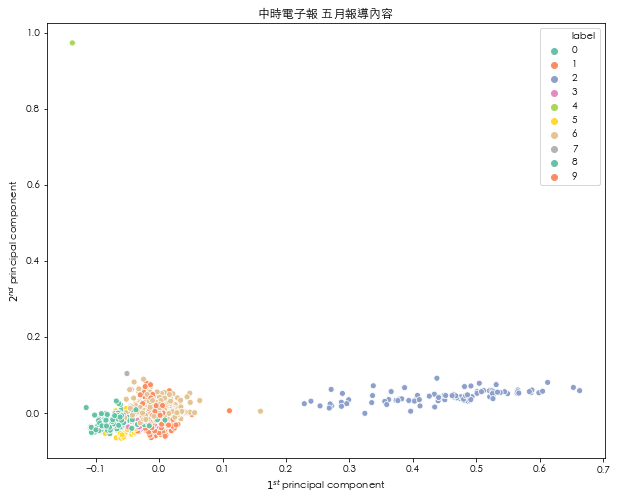

In [29]:
# project to 2d for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_comps = pca.fit_transform(X)

# create a dataframe for plotting
cluster_df = pd.DataFrame({"x": X_comps[:, 0], "y": X_comps[:, 1], "label": labels})

# plot
plt.figure(figsize=(10, 8))
import seaborn as sns
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x="x", y="y", hue="label", data=cluster_df, legend="full", palette="Set2")
plt.title("中時電子報 五月報導內容")
plt.xlabel(r"$1^{st}$ principal component")
plt.ylabel(r"$2^{nd}$ principal component")
plt.savefig("chinatimes-may-topic.png")